# Access CCMP data on Pangeo

This tutorial shows how to access the CCMP wind speed data, makes a few plots of the data, and then compares it to a buoy wind speed.

## CCMP Winds in a cloud-optimized-format for Pangeo

The Cross-Calibrated Multi-Platform (CCMP) Ocean Surface Wind Vector Analyses is part of the NASA Making Earth System Data Records for Use in Research Environments (MEaSUREs) Program. MEaSUREs, develops consistent global- and continental-scale Earth System Data Records by supporting projects that produce data using proven algorithms and input.  If you use this data, please give [credit](https://podaac.jpl.nasa.gov/MEaSUREs-CCMP?sections=about).  For more information, please review the [documentation](https://podaac-tools.jpl.nasa.gov/drive/files/allData/ccmp/L2.5/docs/ccmp_users_guide.pdf). Please note that this data is not recommended for trend calculations.

Data is NRT from 4/1/2019 - 10/4/2020.
The 6-hourly VAM analyses are centered at 0,6,12 and 18z

## Accessing cloud satellite data

- CCMP zarr conversion funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credit:
- [Chelle Gentemann](mailto:cgentemann@faralloninstitute.org), [Farallon Institute](http://www.faralloninstitute.org/), [Twitter](https://twitter.com/ChelleGentemann) - creation of Zarr data store and tutorial
- [Charles Blackmon Luca](mailto:blackmon@ldeo.columbia.edu), [LDEO](https://www.ldeo.columbia.edu/) - help with moving to Pangeo storage and intake update
- [Willi Rath](mailto:wrath@geomar.de), [GEOMAR](https://www.geomar.de/en/), [Twitter](https://twitter.com/RathWilli) - motivated CG to move data to Pangeo!
- [Tom Augspurger](mailto:taugspurger@microsoft.com), [Microsoft](https://www.linkedin.com/in/tom-augspurger-01269315/),[Twitter](https://twitter.com/TomAugspurger) - help updating the data.

#### Zarr data format

 [Zarr](https://zarr.readthedocs.io/en/stable/)

#### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data. You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

#### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`

#### First start by importing libraries

In [1]:
#libs for reading data
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import cartopy.crs as ccrs

#lib for dask gateway
from dask_gateway import Gateway
from dask.distributed import Client
from dask import delayed

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


### Start a cluster, a group of computers that will work together.

(A cluster is the key to big data analysis on on Cloud.)

- This will set up a [dask kubernetes](https://docs.dask.org/en/latest/setup/kubernetes.html) cluster for your analysis and give you a path that you can paste into the top of the Dask dashboard to visualize parts of your cluster.  
- You don't need to paste the link below into the Dask dashboard for this to work, but it will help you visualize progress.
- Try 20 workers to start (during the tutorial) but you can increase to speed things up later

In [2]:
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=75)
client = Client(cluster)
cluster

** ☝️ Don’t forget to click the link above or copy it to the Dask dashboard (orange icon) on the left to view the scheduler dashboard! **

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset (273 GB) initializes nearly instantly, and we can see the full list of variables and coordinates.

### Examine Metadata

For those unfamiliar with this dataset, the variable metadata is very helpful for understanding what the variables actually represent
Printing the dataset will show you the dimensions, coordinates, and data variables with clickable icons at the end that show more metadata and size.

In [3]:
%%time
cat_pangeo = intake.open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml")

ds_ccmp = cat_pangeo.atmosphere.nasa_ccmp_wind_vectors.to_dask()

#calculate wind speed and add attributes to new variable
ds_ccmp['wspd'] = np.sqrt(ds_ccmp.uwnd**2 + ds_ccmp.vwnd**2)
ds_ccmp.wspd.attrs=ds_ccmp.uwnd.attrs
ds_ccmp.wspd.attrs['long_name']='wind speed at 10 meters'

ds_ccmp

CPU times: user 650 ms, sys: 92.5 ms, total: 743 ms
Wall time: 1.42 s


,Array,Chunk
Bytes,163.03 GiB,215.61 MiB
Shape,"(48392, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,163.03 GiB,215.61 MiB
Shape,"(48392, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Plot a global image of the data on 7/4/2020 (randomly chosen day)

``xarray`` makes plotting the data very easy.  A nice overview of plotting with xarray is [here](http://xarray.pydata.org/en/stable/plotting.html).  Details on [.plot](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html#xarray.DataArray.plot)

Below we are plotting the variable `wspd` (wind speed) and `nobs` (number of observations) to show how there is data over the ocean but none over land. CCMP data includes 25 km ERA5 data over land.

CPU times: user 767 ms, sys: 190 ms, total: 956 ms
Wall time: 3min


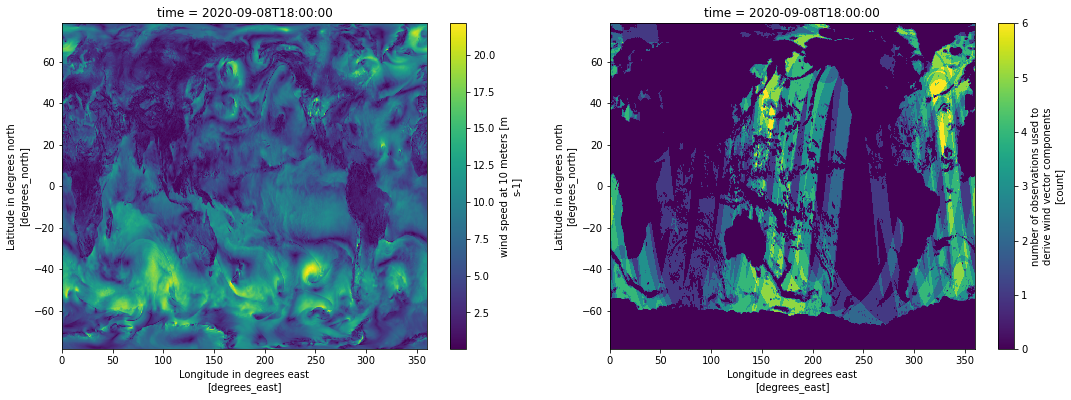

In [4]:
%%time

day = ds_ccmp.sel(time='2020-09-08T18')

fig, ax = plt.subplots(1,2, figsize=(18,6))

day.wspd.plot(ax=ax[0])

day.nobs.plot(ax=ax[1])

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


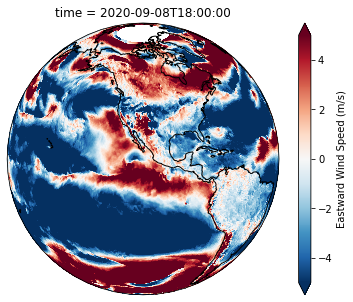

In [5]:
import cartopy
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-110, 20)           # define target coordinate frame
geo = ccrs.PlateCarree()                     # define origin coordinate frame

plt.figure(figsize=(7,5))                    #set the figure size
ax = plt.subplot(1, 1, 1, projection=ortho)  #create the axis for plotting
q = day.uwnd.plot(ax=ax, 
                            transform = geo, 
                            cmap='RdBu_r', #'cmo.thermal', 
                            vmin=-5, 
                            vmax=5,cbar_kwargs={'label':'Eastward Wind Speed (m/s)'}) # plot a colormap in transformed coordinates cmap='OrRd', 
global_extent = ax.get_extent(crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND,color='gray')
ax.add_feature(cartopy.feature.COASTLINE)

#plt.savefig('./../../figures/ccmp_wind_example.png')


### Plot a timeseries of the average wind speed over a region

- use [.sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html#xarray-dataarray-sel) and slice to select a region of data
- use [.mean](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray.DataArray.mean) to calculate the spatial mean
- use [.plot](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html#xarray-dataarray-plot) to plot a timeseries of the mean wind speed

CPU times: user 203 ms, sys: 22.5 ms, total: 225 ms
Wall time: 48.7 s


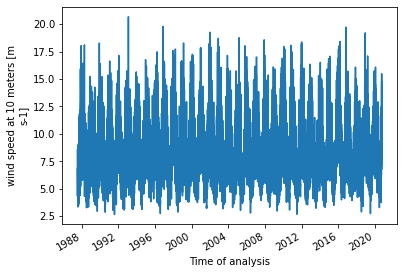

In [6]:
%%time

subset = ds_ccmp.sel(latitude=slice(30,50),longitude=slice(200,210))

ts = subset.mean({'latitude','longitude'},keep_attrs=True)

ts.wspd.plot()

### Make a Hovmoller diagram

- [Hovmoller diagrams](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram) are common plots in oceanography and meteorology to look at propogation of waves. They often have latitude or longitude along the x-axis and time along the y-axis so you can look at how things propogate in time.

distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('getitem-7680cdf45141faec63b553a96087af16', 1, 3)": (), "('getitem-7680cdf45141faec63b553a96087af16', 4, 3)": ()}


CPU times: user 3.12 s, sys: 533 ms, total: 3.65 s
Wall time: 2min 7s


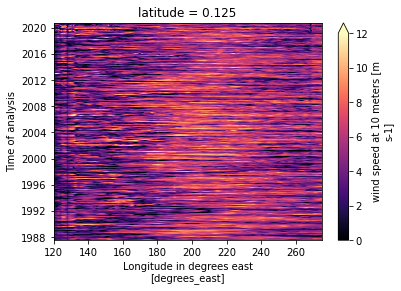

In [7]:
%%time

ds_ccmp.sel(latitude=0.125,longitude=slice(120,275)).wspd.plot(vmin=0,vmax=12,cmap='magma')

### In Feb 2020 a GRL [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL091430) came out connecting 3 closely occuring Typhoons near Korea to the California wildfires
  
"Strong winds that accentuated a fire outbreak in the western United States in early September of 2020 resulted from an atmospheric wave train that spanned the Pacific Ocean. Days before the atmospheric waves developed in the United States, three western Pacific tropical cyclones (typhoons) underwent an extratropical transition over Korea within an unprecedentedly short span of 12 days. "

Using ERA5 winds, Figure 1 showed zonal winds averaged over a box located over NCal/Oregon. On 9/8 and again on 9/24 the zonal winds were strongly negative (Diablo winds) and both events were associated with major fires.

Below, let's do the same figure with CCMP winds - Note that CCMP winds end 10/4/2020, so the data will end at that point.

- First create a timeseries of the 'uwnd' or east-west wind vector for the same region used in the paper above.
- Next plot all the data in grey and then add 2020 data in red.

In [8]:
ts = ds_ccmp.uwnd.sel(longitude=slice(236,239),latitude=slice(41,46)).mean({'latitude','longitude'}).load()

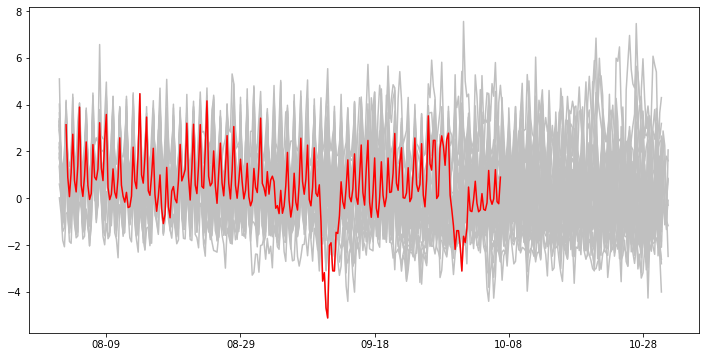

In [9]:
#plot the data
fig, ax = plt.subplots(figsize=(12, 6))
for lyr in range(1979,2021):
    yr = ts.sel(time=slice(str(lyr)+'-08-01',str(lyr)+'-10-29'))
    xx=yr.time.dt.dayofyear+yr.time.dt.hour/24
    ax.plot(xx,yr,color='silver')
    if lyr==2020:
        ax.plot(xx,yr,color='red')
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

### Compare the satellite wind speeds to buoy (in situ) data
Data from NDBC buoys, which measure wind speed are [here](https://dods.ndbc.noaa.gov/) and can be read via an THREDDS server.
- read in NDBC buoy data
- find closest CCMP data and linearly interpolate to buoy location
- examine a timeseries, caluclate bias and STD

In [10]:
%%time
#read in NDBC buoy data
url='https://dods.ndbc.noaa.gov/thredds/dodsC/data/cwind/51003/51003.ncml'

with xr.open_dataset(url) as ds:
    # The longitude is on a -180 to 180, CCMP is 0-360, so make sure to convert
    ds.coords['longitude'] = np.mod(ds['longitude'], 360)
ds

CPU times: user 96.2 ms, sys: 39.9 ms, total: 136 ms
Wall time: 2.27 s


<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 806344)
Coordinates:
  * latitude   (latitude) float32 19.29
  * longitude  (longitude) float32 199.4
  * time       (time) datetime64[ns] 2001-01-09T17:00:00 ... 2017-12-31T22:50:00
Data variables:
    wind_dir   (time, latitude, longitude) float64 ...
    wind_spd   (time, latitude, longitude) float32 ...
Attributes:
    institution:  NOAA National Data Buoy Center and Participators in Data As...
    url:          http://dods.ndbc.noaa.gov
    quality:      Automated QC checks with manual editing and comprehensive m...
    conventions:  COARDS
    station:      51003
    comment:      WESTERN  HAWAII - 205 NM SW of Honolulu, HI
    location:     19.289 N 160.569 W

In [11]:
%%time
#find the time period that both data exist eg. start and stop
time_start = np.max([ds.time[0].data,ds_ccmp.time[0].data])
time_stop = np.min([ds.time[-1].data,ds_ccmp.time[-1].data])

#cut off satellite data to joint period
# then linearly interpolate the data to the buoy location
ccmp_buoy = ds_ccmp.sel(time=slice(time_start,time_stop)).interp(latitude=ds.latitude,longitude=ds.longitude,method='linear')

#cut off buoy data to joint period
ds = ds.sel(time=slice(time_start,time_stop))

CPU times: user 94.1 ms, sys: 1.12 ms, total: 95.2 ms
Wall time: 93.2 ms


In [12]:
%%time

# go from 30 min to 6-hourly sampling, resample with mean for +- 3 hours centered on timestamp
#ds = ds.resample(time='6H',loffset='180min',base=3).mean()  
# OMG!!! resample is sooo slow.  doing this cludge instead, same to within 6 significant digits

ds = ds.rolling(time=36,center=True).mean() 
ds_buoy = ds.interp(time=ccmp_buoy.time,method='nearest')

ds_buoy

CPU times: user 192 ms, sys: 88.7 ms, total: 281 ms
Wall time: 1.82 s


<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 24797)
Coordinates:
  * latitude   (latitude) float32 19.29
  * longitude  (longitude) float32 199.4
  * time       (time) datetime64[ns] 2001-01-09T18:00:00 ... 2017-12-30T18:00:00
Data variables:
    wind_dir   (time, latitude, longitude) float64 nan 154.1 ... 103.5 66.14
    wind_spd   (time, latitude, longitude) float32 nan 4.997 ... 4.236 5.73
Attributes:
    institution:  NOAA National Data Buoy Center and Participators in Data As...
    url:          http://dods.ndbc.noaa.gov
    quality:      Automated QC checks with manual editing and comprehensive m...
    conventions:  COARDS
    station:      51003
    comment:      WESTERN  HAWAII - 205 NM SW of Honolulu, HI
    location:     19.289 N 160.569 W

CPU times: user 109 ms, sys: 8.23 ms, total: 117 ms
Wall time: 6.43 s


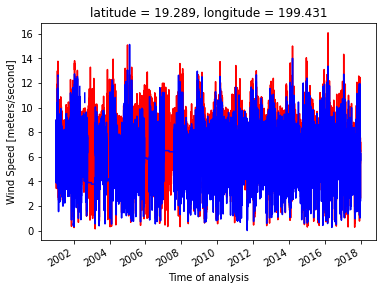

In [13]:
%%time
#plot the data
ccmp_buoy.wspd.plot(color='r')
ds_buoy.wind_spd.plot(color='b')

In [14]:
%%time
# change the chunking in time for the satellite data
ccmp_buoy = ccmp_buoy.chunk({"time": 24797}).compute()

CPU times: user 86.5 ms, sys: 4.2 ms, total: 90.7 ms
Wall time: 6.55 s


In [15]:
%%time
# let's remove the seasonal cycle so we can compare the data more clearly

#for ccmp data create the climatology and anomaly
ts_ccmp_climatology = ccmp_buoy.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=True)
ts_ccmp_anomaly = (ccmp_buoy.groupby('time.dayofyear')-ts_ccmp_climatology).compute()

#for buoy data create the climatology and anomaly
ts_buoy_climatology = ds_buoy.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=True)
ts_buoy_anomaly = (ds_buoy.groupby('time.dayofyear')-ts_buoy_climatology).compute()

CPU times: user 2.89 s, sys: 45.8 ms, total: 2.94 s
Wall time: 2.86 s


CPU times: user 34.9 ms, sys: 47 µs, total: 35 ms
Wall time: 34.3 ms


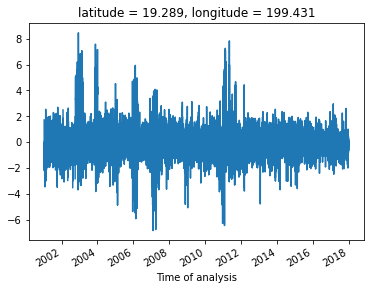

In [16]:
%%time
#plot the data
(ts_ccmp_anomaly.wspd-ts_buoy_anomaly.wind_spd).plot()

In [17]:
%%time
#calculate the mean difference and standard deviation

print('buoy minus satellite wind speeds')
rdif = (ts_buoy_anomaly.wind_spd-ts_ccmp_anomaly.wspd)
print('mean:',rdif.mean().data)
print('std:',rdif.std().data)

buoy minus satellite wind speeds
mean: -0.00028690338
std: 1.0847609043121338
CPU times: user 4.69 ms, sys: 1.16 ms, total: 5.85 ms
Wall time: 4.56 ms


### Masking satellite data and looking at frequency of low/high wind speeds.
- Make a land/ocean/ice mask to show where there is actually data

#### Three different ways to mask the data
1. A daily mask that removes data with sea ice and land
- sum over time for nobs (number of observations) variable
- average over a month so that land and monthly sea ice are masked out
2. A mask that removes all data that over land or where there is 'permanent' sea ice
- find when nobs is > 0
3. A climatology mask that removes all data that over land or where there has ever been sea ice
- sum over time for nobs (number of observations) variable
- average over a month so that land and monthly sea ice are masked out

#### Apply the mask 
- over land, CCMP is ERA5 data
- for many ocean applications a land / sea ice mask is needed
- below are some different mask options that use the CCMP data to generate a mask


In [18]:
def mask_data(ds,type):
    if type=='daily': #daily mask removes sea ice and land
        mask_obs = ds.nobs.rolling(time=180,center=True).max('time')  #4 per day 30 days = 180 rolling window
        cutoff = 0
    if type=='land':  # land mask only (includes data over sea ice)
        mask_obs = ds.nobs.sum({'time'},keep_attrs=True)  #this will give you a LAND mask
        cutoff = 0
    if type=='climatology':  #climatology mask removes max sea ice extent and land
        test = ds.nobs.coarsen(time=16, boundary="trim").max() #subsample to every 4 days
        test = test/test #normalize
        mask_obs = test.rolling(time=10,center=True).max('time')
        mask_obs = mask_obs.sum({'time'},keep_attrs=True).compute()
        cutoff = mask_obs.sel(longitude=slice(220,230),latitude=slice(10,20)).min() #pick area in middle pacific to get #obs
        cutoff = cutoff-cutoff*.2 #just because there are some areas with a little less data eg. itcz
    dy_mask = (mask_obs>cutoff).compute()  #computing the mask speeds up subsequent operations
    masked = ds.where(dy_mask)
    return masked,dy_mask

- For this tutorial we will use the climatology mask

- This code will take ~10 min to run through the entire dataset to create the climatology mask

CPU times: user 613 ms, sys: 6.48 ms, total: 619 ms
Wall time: 3.21 s


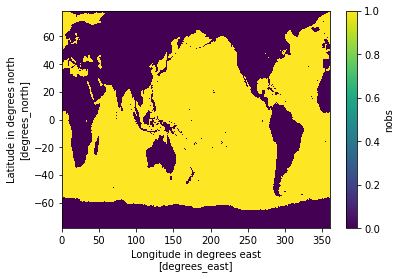

In [19]:
%%time

subset = ds_ccmp.sel(time='2018')

masked,mask_obs = mask_data(subset,'climatology')

mask_obs.plot()

distributed.client - WARNING - Couldn't gather 3 keys, rescheduling {"('getitem-ea0c3fac679630cf4795077dde14fa4c', 1, 4)": (), "('getitem-ea0c3fac679630cf4795077dde14fa4c', 3, 6)": (), "('getitem-ea0c3fac679630cf4795077dde14fa4c', 1, 2)": ()}


CPU times: user 507 ms, sys: 40.6 ms, total: 548 ms
Wall time: 46.3 s


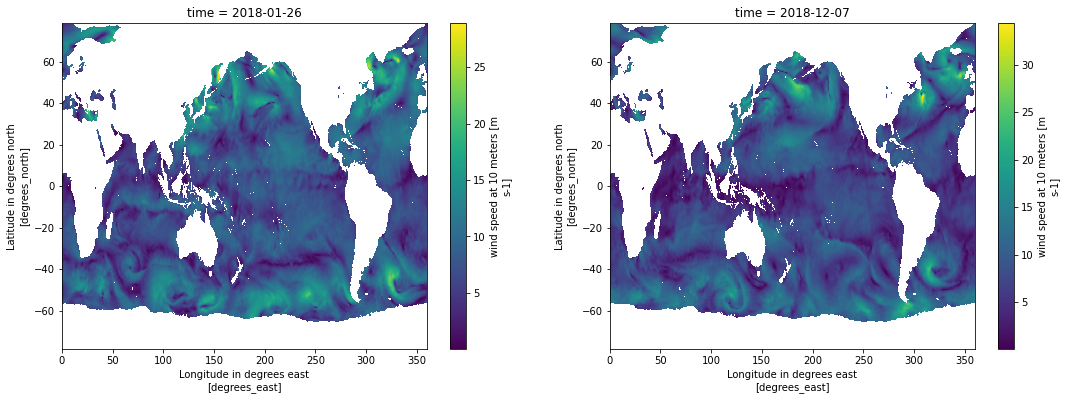

In [20]:
%%time

fig, ax = plt.subplots(1,2, figsize=(18,6))

masked.wspd[100,:,:].plot(ax=ax[0])

masked.wspd[-100,:,:].plot(ax=ax[1])


### When are there low or high wind speeds at each location?

- calculate percentage of low/high winds at each location

- show a spatial map showing a climatology of roughness.  


In [21]:
%%time
from xhistogram.xarray import histogram

# wspd_bin = 0 gives fraction of winds <= 2 m/s where strong diurnal warming of the ocean surface may be present

wspd_levels = np.array([0,2,1000]) 

wspd_hist = histogram(subset.wspd, 
                      bins=[wspd_levels], 
                      dim=['time'], 
                      density=False)

wspd_hist = wspd_hist/wspd_hist.sum('wspd_bin')

wspd_hist.load()

CPU times: user 175 ms, sys: 24.4 ms, total: 199 ms
Wall time: 14.2 s


<xarray.DataArray 'histogram_wspd' (latitude: 628, longitude: 1440, wspd_bin: 2)>
array([[[0.01369863, 0.98630137],
        [0.01438356, 0.98561644],
        [0.01438356, 0.98561644],
        ...,
        [0.01506849, 0.98493151],
        [0.01506849, 0.98493151],
        [0.01369863, 0.98630137]],

       [[0.01575342, 0.98424658],
        [0.01506849, 0.98493151],
        [0.01506849, 0.98493151],
        ...,
        [0.01643836, 0.98356164],
        [0.01712329, 0.98287671],
        [0.01643836, 0.98356164]],

       [[0.01438356, 0.98561644],
        [0.01438356, 0.98561644],
        [0.01369863, 0.98630137],
        ...,
...
        ...,
        [0.0369863 , 0.9630137 ],
        [0.03767123, 0.96232877],
        [0.03630137, 0.96369863]],

       [[0.03767123, 0.96232877],
        [0.03972603, 0.96027397],
        [0.03767123, 0.96232877],
        ...,
        [0.03630137, 0.96369863],
        [0.03493151, 0.96506849],
        [0.0390411 , 0.9609589 ]],

       [[0.04041096, 0.95958904],
        [0.03835616, 0.96164384],
        [0.03835616, 0.96164384],
        ...,
        [0.04109589, 0.95890411],
        [0.04041096, 0.95958904],
        [0.04041096, 0.95958904]]])
Coordinates:
  * latitude   (latitude) float32 -78.38 -78.12 -77.88 ... 77.88 78.12 78.38
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * wspd_bin   (wspd_bin) float64 1.0 501.0

In [22]:
%%time
from xhistogram.xarray import histogram

# wspd_bin = 1 gives fraction of winds > 10 m/s where wind speed accuracy decreases

wspd_levels = np.array([0,10,1000]) 
wspd_hist2 = histogram(subset.wspd, 
                      bins=[wspd_levels], 
                      dim=['time'], 
                      density=False)

wspd_hist2 = wspd_hist2/wspd_hist2.sum('wspd_bin')

wspd_hist2.load()

whist = xr.concat([wspd_hist.isel(wspd_bin=0),wspd_hist2.isel(wspd_bin=1)],dim='wspd_bin')

CPU times: user 157 ms, sys: 27.6 ms, total: 185 ms
Wall time: 16.5 s


CPU times: user 1.5 s, sys: 387 ms, total: 1.89 s
Wall time: 1.41 s


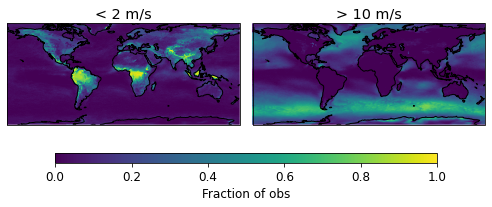

In [23]:
%%time
#plot the data

plt.rcParams['figure.figsize'] = (8.0,4.0)
plt.rcParams.update({'font.size': 12})
fg = whist.plot(vmin=0, vmax=1,
    col="wspd_bin",
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.PlateCarree()
    },
    cbar_kwargs={"label":'Fraction of obs',"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    robust=True,
)
tstr = ['< 2 m/s','> 10 m/s']
for i, ax in enumerate(fg.axes.flat):
    ax.set_title(tstr[i]) 
fg.map(lambda: plt.gca().coastlines())

### Calculate using only data over the ocean
- use the mask to remove the land data

CPU times: user 1.3 s, sys: 125 ms, total: 1.43 s
Wall time: 1.3 s


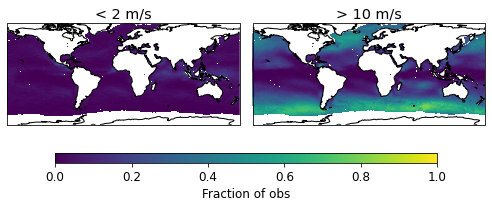

In [24]:
%%time

masked = whist.where(mask_obs>0)

fg = masked.plot(vmin=0, vmax=1,
    col="wspd_bin",
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.PlateCarree()
    },
    cbar_kwargs={"label":'Fraction of obs',"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    robust=True,
)
tstr = ['< 2 m/s','> 10 m/s']
for i, ax in enumerate(fg.axes.flat):
    ax.set_title(tstr[i]) 
fg.map(lambda: plt.gca().coastlines())


In [25]:
client.close()